In [1]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\Thorben\AppData\Local\Programs\Python\Python312\Lib\site-packages\brian2\utils\logger.py:23: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.4.1)
  import scipy


In [2]:
# converting functions for voltage to phase

# --- Parameter ---
N       = 10_000  # 10_000
K       = 1_000   # 1_000

V_T     = 1.0
V_R     = 0.0

nu      = 10*Hz
J_0     = 1.0
tau_m   = 10*ms

I_0 = nu * J_0 * tau_m
Iext_const = np.sqrt(K) * I_0
w_inh = J_0/np.sqrt(K)

def T_free(tau = tau_m, VT=V_T, VR=V_R, I_ext=Iext_const):
    ln = np.log((VT-I_ext)/(VR-Iext_const))
    return -tau * ln

def phi(V):
    Tfree = T_free(tau = tau_m, VT=V_T, VR=V_R, I_ext=Iext_const)
    return - tau_m / Tfree *(np.log((V-Iext_const)/(V_R-Iext_const)))

def phi_inv(phi, C = Iext_const, tau_m = tau_m):
    Tfree = T_free(tau = tau_m, VT=V_T, VR=V_R, I_ext=Iext_const)/ms
    exponent = - phi * Tfree / (tau_m/ms)
    return (V_R - C) * np.exp(exponent) + C

In [3]:
def run_w_startvector(runtime, startvector):   #enter the runtime in seconds but with the unit
    
    start_scope()
    # Brian Zeitschritt (bei kontinuierlicher Simulation)

    defaultclock.dt = 0.1*ms

    # Simulationsdauer
    


    # --- Parameter ---
    N       = 10_000  # 10_000
    K       = 1_000   # 1_000

    V_T     = 1.0
    V_R     = 0.0

    nu      = 10*Hz
    J_0     = 1.0
    tau_m   = 10*ms




        # balanced-state prediction (eq. (5)): nu ~ nu_bal = I_0/(J_0*tau_m)  -> I_0 ~ nu*J_0*tau_m
    I_0 = nu * J_0 * tau_m

    Iext_const = np.sqrt(K) * I_0  # These inputs counteract the constant excitatory current
    w_inh = J_0/np.sqrt(K)  # neurons receive exclusively inhibitory recurrent inputs
    # NOTE S = Synapses(G, G, on_pre="V -= w_inh")  # inhibitory undelayed pulse 
                


    # --- Neuronmodell (Voltage-LIF) ---
    # Paper: tau_m dV/dt = -V + I(t) (1), mit I(t)=sqrt(K)*I_0 - (J_0/sqrt(K))*sum delta(...)
    # In Brian: wir modellieren I_ext als konstanten Term im ODE und synaptische Pulse als Sprung in V.
    eqs = """
    dV/dt = (-V + I_ext)/tau_m : 1  # NOTE dimensionslos (V normiert und dimensionslos im Paper)
    I_ext : 1                       # NOTE dimensionslos
    """

    G = NeuronGroup(
        N,
        model=eqs,
        threshold="V >= V_T",
        reset="V = V_R",
        method="euler"
    )

    # Initialisierung
    G.V = startvector    # TODO: alternative Initialisierung?
    G.I_ext = Iext_const    # REVIEW: Ich habe aus der Übung nicht verstanden, wie wir die Delta-Funktion hinbekommen..


    # --- Konnektivität: gerichteter Erdős–Rényi mit mittlerem In-degree K ---
    p = K / (N-1)   # p in (0,1)



    seed(0)           # Brian2 seed
    S = Synapses(G, G, on_pre="V -= w_inh")  # inhibitory undelayed pulse 
    S.connect(condition='i!=j', p=p)



    #sp_mon = SpikeMonitor(G)

    mon_all_V = StateMonitor(G, 'V', record=True)


    # --- Run ---
    print(f"\nRunning simulation for T = {runtime}...")

    # Set BOTH seeds right after start_scope()

    run(runtime)
    mon_endvalues = np.array(G.V)
    print("Done!")

    return mon_endvalues, mon_all_V



In [4]:
# create an initial random vector to have a random starting point for the simulation
initial_randvector = np.random.rand(10000)
# run it for 8 seconds and return the resulting voltage
runtime = 8*second
V_0, trajectory_V_0  = run_w_startvector(runtime, initial_randvector)


#run it again but now from the resulting vector of the previous run
runtime = 1*second
V_5, trajectory_V_5  = run_w_startvector(runtime, V_0)


WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]



Running simulation for T = 8. s...
Done!

Running simulation for T = 1. s...
Done!


In [5]:
#convert to phase
phase_V_0 = phi(V_0)

#create and add the random vector
r = np.random.normal(0,1,N)
r /= np.linalg.norm(r)
#print(r)
phase_V_0_shift = phase_V_0 + r
#print(phase_V_0)
#print(phase_V_0_shift)

#convert back to voltages
V_0e = phi_inv(phase_V_0_shift)
#print(V_0)
#print(V_0e)

In [6]:
#Now run as before but from the slighly altered starting point
V_5e, trajectory_V_5e = run_w_startvector(runtime, V_0e)
#print(V_5)
#print(V_5e)


#Calculate the difference of the two trajectories (taking the absolute values)
diff_eps = np.abs(trajectory_V_5.V - trajectory_V_5e.V)

#convert voltage to phase again
diff_eps_phase = phi(diff_eps)

# sum this up over the neurons for all the timesteps
diff_over_neurons = diff_eps_phase.sum(axis=0)



Running simulation for T = 1. s...
Done!


WARNING    C:\Users\Thorben\AppData\Local\Temp\ipykernel_20616\112809237.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
 [py.warnings]


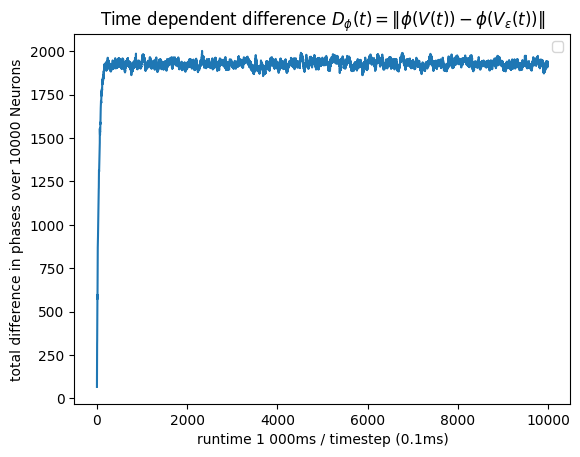

In [7]:
#plot this now

plt.plot(diff_over_neurons)
plt.xlabel(f'runtime 1 000ms / timestep (0.1ms)')
plt.ylabel(f'total difference in phases over {N} Neurons')
plt.title(r'Time dependent difference $D_{\phi}(t) = \|\phi(V(t)) - \phi(V_{\varepsilon}(t))\|$')
plt.legend()